## **0. Importation des librairies**

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import operator, math, os, glob
import torch.nn as nn
from matplotlib.pyplot import imread

## **1. Téléchargement de la base de données Wang**

In [ ]:
!wget https://cluster.ig.umons.ac.be/workshop_ia/image.orig.zip
!unzip image.orig.zip

## **Question 1 : définir la fonction de calcul de distance euclidéenne**

In [2]:
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

## **Définition du modèle et du niveau d'extraction des caractéristiques**

In [5]:
model0 = models.vgg16(pretrained=True)
model1 = models.resnet50(pretrained=True)
model2 = models.efficientnet_b0(pretrained=True)


In [ ]:
model0

## VGG16

In [10]:
model0.classifier = nn.Sequential(*list(model0.classifier.children())[:-1])
feature_extractor = nn.Sequential(
    model0.features,
    model0.avgpool,
    nn.Flatten(start_dim=1),
    model0.classifier
)

## Resnet50

In [12]:
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
feature_extractor = nn.Sequential(*list(model1.children())[:-1])
feature_extractor

## EfficientNet

In [ ]:
model2

In [16]:
model2.classifier = nn.Sequential(*list(model2.classifier.children())[:-1])
feature_extractor = nn.Sequential(
    model2.features,
    model2.avgpool,
    nn.Flatten(start_dim=1),
    model2.classifier
)

**Extraction des caractéristiques**

In [6]:
input_folder = "image.orig"  # Dossier contenant les images
output_folder = "VGG16"  # Dossier de sauvegarde des features
os.makedirs(output_folder, exist_ok=True)  # Créer le dossier s'il n'existe pas
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Taille standard de VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
feature_extractor.eval()  # Mode évaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")     # Charger l'image
    image = transform(image).unsqueeze(0).to(device)  # Appliquer les transformations et ajouter une dimension batch
    with torch.no_grad():                             # Désactiver le calcul des gradients
        features = feature_extractor(image)
    return features.cpu().numpy().squeeze().flatten()

In [ ]:
# Parcourir le dossier et traiter chaque image
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Vérifier le format de l'image
        image_path = os.path.join(input_folder, filename)
        features = extract_features(image_path)

        # Enregistrer les features sous forme de fichier texte
        output_path = os.path.join(output_folder, filename.split('.')[0] + ".txt")
        np.savetxt(output_path, features, fmt="%.6f")  # Format en 6 décimales

        print(f"Features extraites et enregistrées : {output_path}")

print("Extraction terminée !")

**Charger les caractéristiques**

In [10]:
def load_features_with_images(feature_folder, image_folder):

    feature_files = sorted(glob.glob(os.path.join(feature_folder, "*.txt")))

    features_dict = {}
    image_dict = {}

    for file in feature_files:
        feature_vector = np.loadtxt(file, ndmin=1)  # Charger les features
        base_name = os.path.splitext(os.path.basename(file))[0]  # Récupérer le nom sans extension

        # Stocker les features
        features_dict[base_name] = feature_vector

        # Trouver l'image correspondante
        image_path_jpg = os.path.join(image_folder, base_name + ".jpg")


        # Vérifier l'existence des images
        if os.path.exists(image_path_jpg):
            image_dict[base_name] = image_path_jpg

        else:
            print(f"Aucune image trouvée pour {file} !")

    print(f"{len(features_dict)} caractéristiques chargées avec images depuis {feature_folder}")

    return features_dict, image_dict

In [11]:
features_dict, image_dict = load_features_with_images(output_folder, input_folder)

1000 caractéristiques chargées avec images depuis VGG16


**Recherche des k voisins**

In [12]:
def getkVoisins(features_dict, query_name, k):
    """
    Trouve les `k` voisins les plus proches d'une image requête en utilisant la distance euclidienne.

    - `features_dict` : Dictionnaire {nom_fichier: feature_vector}
    - `query_name` : Nom du fichier de l'image requête (sans extension)
    - `k` : Nombre de voisins à retourner.

    Retourne :
    - Liste des `k` noms d'images les plus proches avec leur distance.
    """
    if query_name not in features_dict:
        raise ValueError(f"L'image requête '{query_name}' n'existe pas dans les features !")

    query_feature = features_dict[query_name]
    distances = []

    for name, feature_vector in features_dict.items():
        dist = euclidean_distance(query_feature, feature_vector)  # Distance euclidienne
        distances.append((name, dist))  # Stocker le nom et la distance

    # Trier par distance croissante et récupérer les `k` plus proches
    distances.sort(key=lambda x: x[1])

    return distances[:k]  # Retourner les `k` plus proches voisins

In [13]:
def recherche(query_name, features_dict, image_dict, top=20):
    """
    Recherche les `top` images les plus similaires à une image requête.

    - `query_name` : Nom du fichier image requête (sans extension).
    - `features_dict` : Dictionnaire {nom_fichier: feature_vector}.
    - `image_dict` : Dictionnaire {nom_fichier: chemin_image}.
    - `top` : Nombre d'images similaires à retourner.

    Retourne :
    - `nom_image_requete` : Nom de l’image requête.
    - `nom_images_proches` : Liste des images similaires.
    """
    voisins = getkVoisins(features_dict, query_name, top)

    # Récupérer les chemins des images similaires
    nom_images_proches = [image_dict[v[0]] for v in voisins if v[0] in image_dict]

    # Affichage de l'image requête
    plt.figure(figsize=(5, 5))
    plt.imshow(imread(image_dict[query_name]), cmap='gray', interpolation='none')
    plt.title("Image requête")

    nom_image_requete = os.path.basename(image_dict[query_name])
    print(f"Image requête : {nom_image_requete}")

    # Affichage des images proches
    plt.figure(figsize=(25, 25))
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    for j in range(min(top, len(nom_images_proches))):
        plt.subplot(top // 4, top // 5, j + 1)
        plt.imshow(imread(nom_images_proches[j]), cmap='gray', interpolation='none')
        plt.title(f"Image proche n°{j}")

    return nom_image_requete, nom_images_proches

Image requête : 778.jpg


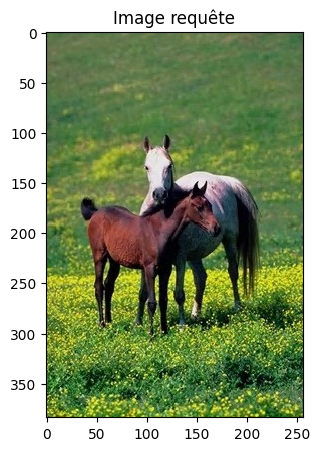

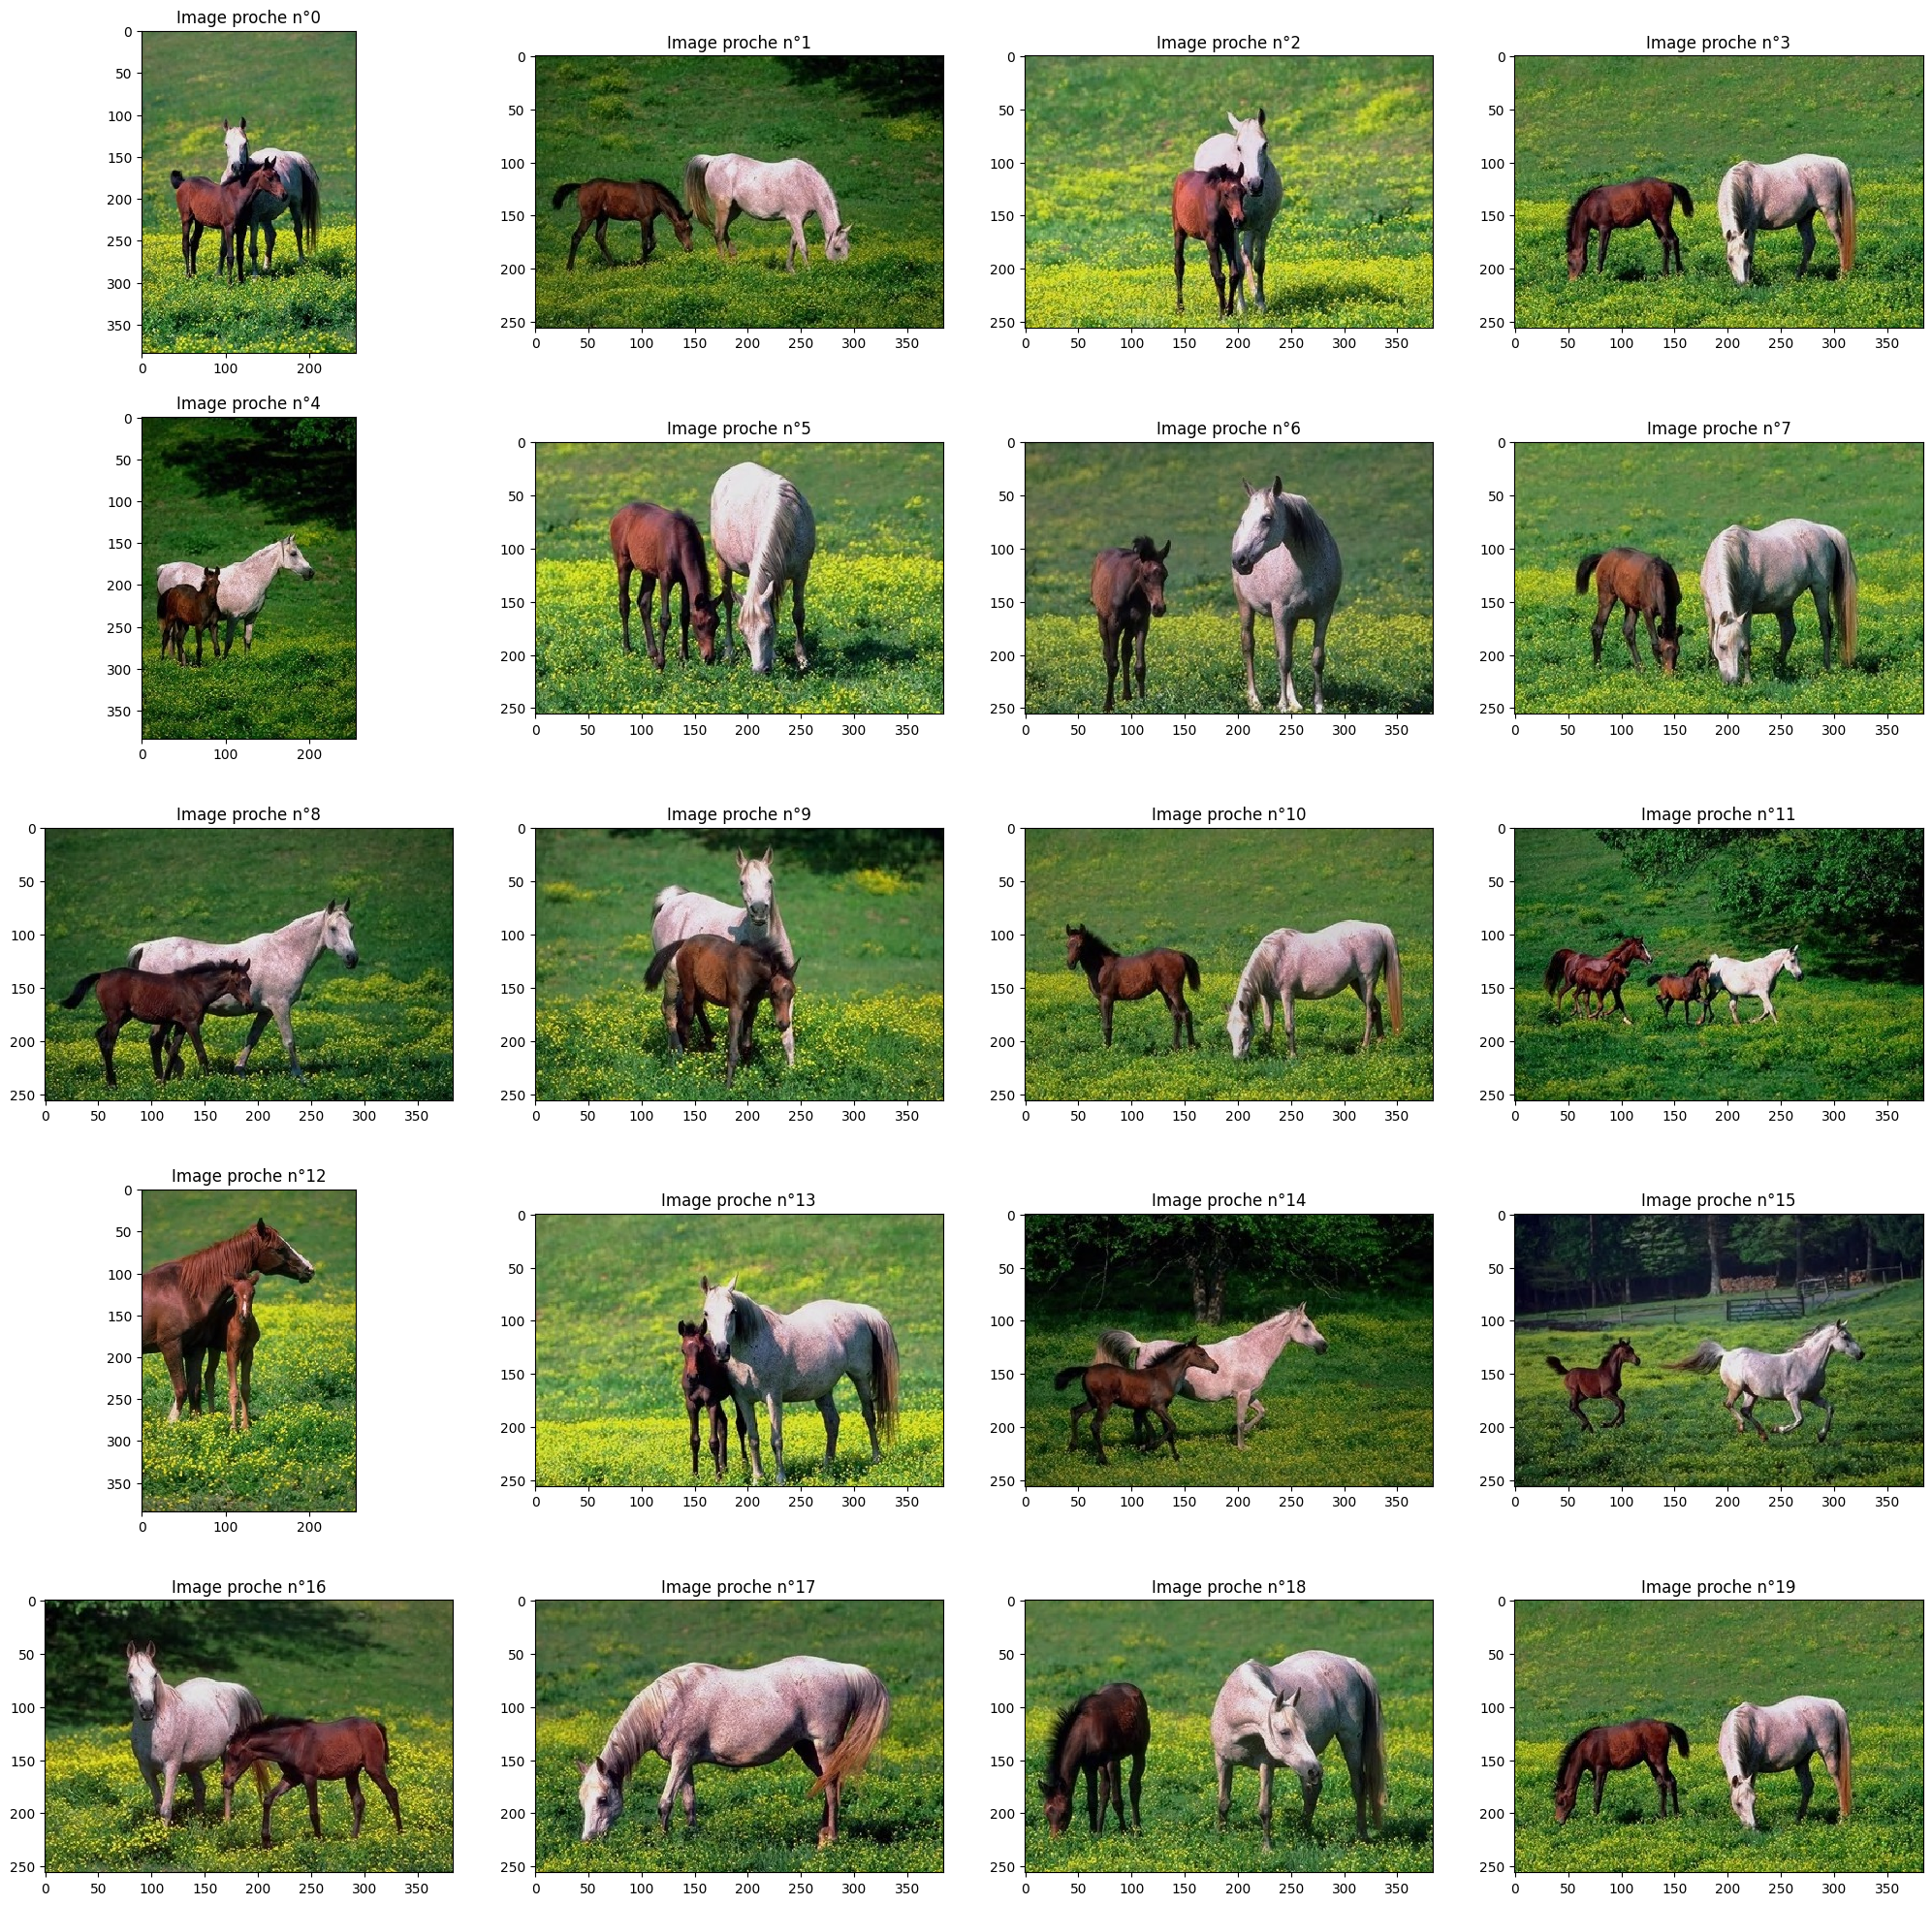

In [14]:
query_name = "778"
nom_image, proches = recherche(query_name, features_dict, image_dict, top=20)

**Calcul des courbes R/P**

In [15]:
def Compute_RP( top, nom_image_requete, images_proches):
    """
    Calcule et enregistre la courbe Rappel-Précision (RP) pour une image requête avec un `top` donné.

    - `RP_file` : Chemin du fichier où enregistrer les valeurs RP.
    - `top` : Nombre d'images les plus proches analysées.
    - `nom_image_requete` : Nom de l'image requête (ex: "107").
    - `nom_images_non_proches` : Liste des noms des images non proches (ex: ["102", "205", ...]).

    Résultat :
    - Fichier `.txt` contenant les valeurs de RP.
    """

    # 📌 Initialisation
    rappel_precision = []
    rp = []

    position1 = int(os.path.splitext(os.path.basename(nom_image_requete))[0]) // 100  # Identifier le groupe de l'image requête

    # 📌 Boucle pour déterminer si chaque image est pertinente ou non
    for j in range(top):
        position2 = int(os.path.splitext(os.path.basename(images_proches[j]))[0]) // 100  # Groupe de l'image voisine
        if position1 == position2:
            rappel_precision.append("pertinent")
        else:
            rappel_precision.append("non pertinent")

    # 📌 Boucle pour calculer le Rappel et la Précision
    val = 0  # Nombre d'images pertinentes accumulées
    for i in range(top):
        if rappel_precision[i] == "pertinent":
            val += 1  # Augmenter si l'image est pertinente

        precision = (val / (i + 1)) * 100  # Précision en pourcentage
        rappel = (val / top) * 100  # Rappel en pourcentage
        rp.append(f"{precision} {rappel}")  # Stocker les valeurs

    RP_file = str(int(os.path.splitext(os.path.basename(nom_image_requete))[0])) + 'RP.txt'
    # 📌 Sauvegarde dans un fichier texte
    with open(RP_file, 'w') as s:
        for a in rp:
            s.write(str(a) + '\n')

    print(f"✅ RP enregistré dans {RP_file}")

In [16]:
rp_tensor = Compute_RP(20, query_name, proches)

✅ RP enregistré dans 778RP.txt


In [17]:
def Display_RP(fichier):
    """
    Affiche la courbe Rappel-Précision (RP) à partir d'un fichier texte contenant les valeurs.

    - `fichier` : Chemin du fichier `.txt` contenant les valeurs RP.

    La courbe affiche :
    - Axe X : Rappel (Recall)
    - Axe Y : Précision (Precision)
    """

    # Charger les données depuis le fichier `.txt`
    x, y = [], []

    with open(fichier, 'r') as csvfile:
        for line in csvfile:
            values = line.strip().split()
            if len(values) == 2:  # Vérifier que la ligne contient bien 2 valeurs
                x.append(float(values[0]))  # Précision
                y.append(float(values[1]))  # Rappel

    # Convertir en tensor PyTorch (optionnel si on veut les manipuler après)
    x_tensor = torch.tensor(x)
    y_tensor = torch.tensor(y)

    # Affichage de la courbe RP
    plt.figure(figsize=(8, 6))
    plt.plot(y_tensor, x_tensor, 'C1', label="VGG16")
    plt.xlabel('Rappel (Recall)')
    plt.ylabel('Précision (Precision)')
    plt.title("Courbe Rappel/Précision (RP)")
    plt.legend()
    plt.grid(True)
    plt.show()

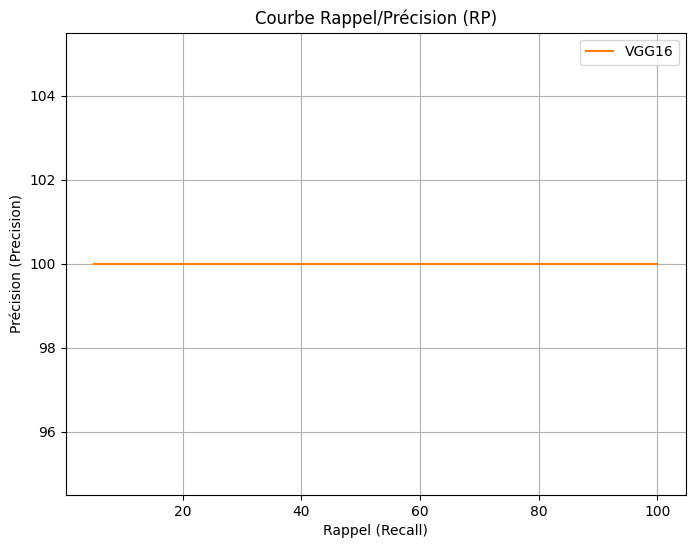

In [18]:
Display_RP("778RP.txt")